# DESIGN PROJECT

## Mise au point d’un système de caméra stéréoscopique pour l’estimation du débit des rivières

In [1]:
#Packages:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from camera_matrix import camera_matrix

In [2]:
# Read a sequence of 2 stereoscopic images, synchronized (frame 107 to 131 for video 1, frame 45 to 69 for video 2)
cap0 = cv2.VideoCapture("/Users/nilsmanni/Desktop/MA2/design_project/vid1_dx.MP4")
cap1 = cv2.VideoCapture("/Users/nilsmanni/Desktop/MA2/design_project/vid1_sx.MP4")

camera_droite = "img_d"
camera_gauche = "img_g"

def save_BW_img(cap):
    image= []
    while True:
  # Lire l'image suivante de la vidéo
        ret, frame = cap.read()

  # Vérifier si la fin de la vidéo a été atteinte
        if not ret:
            break

  # Convertir l'image en noir et blanc
        img_gray= cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        image.append(img_gray)
    cv2.destroyAllWindows()
    cap.release() 
    return image

        
dx_images = save_BW_img(cap0)
sx_images = save_BW_img(cap1)


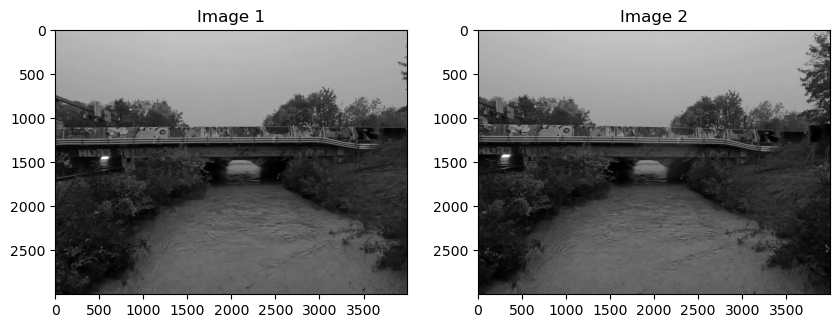

In [3]:
# Show two synchronized images
from PIL import Image
import matplotlib.pyplot as plt

# Assuming you already have bw_images from the previous code

# Access the first two images
image1 = sx_images[0]
image2 = dx_images[0]

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left subplot
axes[0].imshow(image1, cmap='gray')
axes[0].set_title('Image 1')

# Plot the second image on the right subplot
axes[1].imshow(image2, cmap='gray')
axes[1].set_title('Image 2')

# Display the images side by side
plt.show()

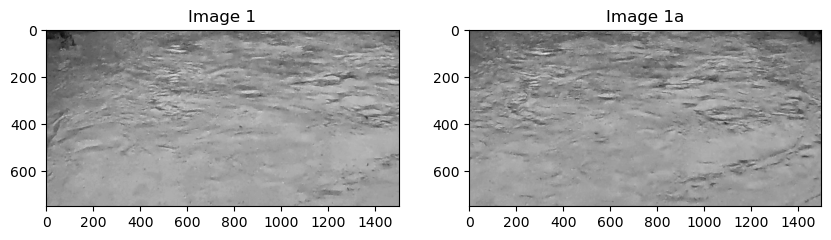

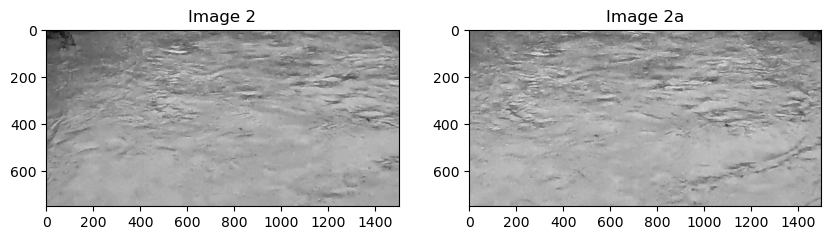

In [4]:
# Assuming you already have bw_images from the previous code

# Define the y-axis range
start_y = 2000
end_y = 2750

# define the x-axis range
start_x = 1250
end_x = 2750
# Define the size of the stripe
stripe_height = end_y - start_y
stripe_width = end_x - start_x

# Create an empty list to store the selected stripes
sx_stripes = []

# Loop through the images and select the stripe for each image
for img in sx_images:
    # Convert the image to a numpy array
    img_array = np.array(img)

    # Select the stripe using array slicing
    selected_stripe = img_array[start_y:end_y, start_x:end_x]

    # Append the selected stripe to the list
    sx_stripes.append(selected_stripe)

    dx_stripes = []

# Loop through the images and select the stripe for each image
for img in dx_images:
    # Convert the image to a numpy array
    img_array = np.array(img)

    # Select the stripe using array slicing
    selected_stripe = img_array[start_y:end_y, start_x:end_x]

    # Append the selected stripe to the list
    dx_stripes.append(selected_stripe)

# Now, 'stripes' is a list containing the selected stripes from each image



# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left subplot
axes[0].imshow(sx_stripes[0], cmap='gray')
axes[0].set_title('Image 1')

# Plot the second image on the right subplot
axes[1].imshow(dx_stripes[0], cmap='gray')
axes[1].set_title('Image 1a')

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left subplot
axes[0].imshow(sx_stripes[1], cmap='gray')
axes[0].set_title('Image 2')

# Plot the second image on the right subplot
axes[1].imshow(dx_stripes[1], cmap='gray')
axes[1].set_title('Image 2a')

# Display the images side by side
plt.show()

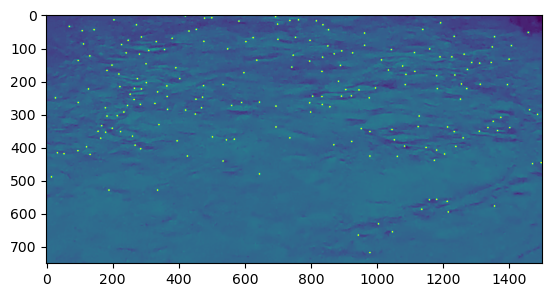

(<matplotlib.image.AxesImage at 0x143ded010>, None)

In [14]:
nb_points = 200
corners = cv2.goodFeaturesToTrack(dx_stripes[0], nb_points,0.01,20)
corners = np.intp(corners)
 
img_circles = dx_stripes[0].copy()

for i in corners:
 x,y = i.ravel()
 cv2.circle(img_circles,(x,y),3,255,-1)
 
plt.imshow(img_circles),plt.show()

In [15]:
def NCC_window(x,y, image): # normalized cross correlation window of 9x9 around our pixel of 
    # Do not forget that if x0-4 or x0+5 is out of the image, we will not take into account this tracking point. 
    NCC = image[y-4:y+5, x-4:x+5] # rows and columns are switched in the image ( image size is 750x1500)
    return NCC

In [16]:
# 1. on recupere les coordonnées :
print(corners[:,0,:2].ravel().shape)
coord_track = corners[:,0,:2].ravel().reshape(nb_points,2)
x,y = coord_track[0, :]
print(x,y)

(400,)
852 93


In [17]:
def tracking(x0,y0,image, NCC):
    match = 1
    x1 = 0
    y1 = 0
    for x in range(x0-7, x0+7): 
        for y in range(y0-7, y0+7):
            img_comp = NCC_window(x,y,image)
            res = cv2.matchTemplate(img_comp,NCC, cv2.TM_SQDIFF_NORMED)
            if res < match: 
                match = res
                x1 = x
                y1 = y
    return(x1, y1)

In [23]:
displacement = np.zeros((nb_points,20,2)) # modifier le 50 pour que ce soit la taille de coord_track
point_i = 0
point_delete = []
for x,y in coord_track: # bug sur le deuxieme point parce que (479,9) trop proche du bord de l'image... donc peut pas check les 15 pixels autour...
    for i in range(1, 21):
        if x< 11 or x > 1489 or y < 11 or y > 714: 
            #stock les points à enlever
            point_delete= np.append(point_delete, point_i)
            break #skip au prochain point
        NCC = NCC_window(x,y, dx_stripes[i-1])
        displacement[point_i, i-1 ,:]= x,y
        x,y = tracking(x,y, dx_stripes[i], NCC)
    point_i += 1
point_delete= point_delete.astype(int)
displacement = np.delete(displacement,point_delete,0 )

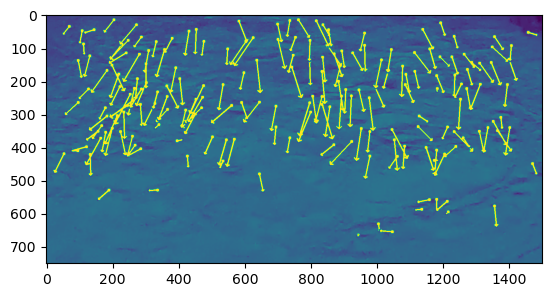

(<matplotlib.image.AxesImage at 0x153affd90>, None)

In [24]:
img_circles = dx_stripes[0].copy()
for i in range(displacement.shape[0]):
    x0,y0 = displacement[i,0,:]
    cv2.circle(img_circles,(int(x0),int(y0)),5,255,-1)
    x1,y1 = displacement[i,19,:]
    cv2.circle(img_circles,(int(x1),int(y1)),5,(70,255,212),-1)
    cv2.arrowedLine(img_circles, (int(x0),int(y0)), (int(x1),int(y1)), 255, 4)

plt.imshow(img_circles),plt.show()

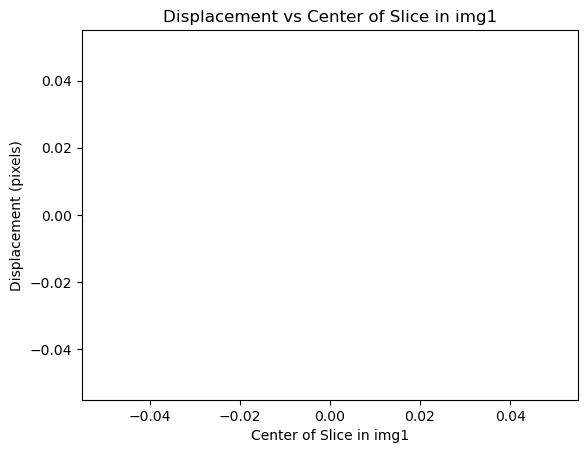

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have two images named img1 and img2 (500x4000 pixels each)

# Set the size of the slices
slice_size = 500
img1 = dx_stripes[0]
img2 = sx_stripes[0]
img1_slice = img1[:, :slice_size]

# Initialize lists to store results
max_correlation_values = []
max_corr_center2_values = []
displacement_values = []

# Iterate through centers of the slice in img1
for center1 in range(slice_size, img1.shape[1] - 2 * slice_size - 1, 100):
    # Extract the slice from img1
    slice_img1 = img1[:, center1:center1 + slice_size]

    # Initialize variables for maximum correlation and displacement
    max_corr_value = -np.inf
    max_corr_center2 = None

    # Iterate through centers of the slice in img2
    for center2 in range(center1, center1 + slice_size):  # Assuming up to 250 pixels displacement
        # Extract the slice from img2
        slice_img2 = img2[:, center2:center2 + slice_size]

        # Calculate the cross-correlation using FFT
        # corr_result = correlate2d(slice_img1, slice_img2, mode='same', boundary='wrap')
        # Alternative: Correlation coefficient R (square root of r2)
        corr_result = np.corrcoef(np.reshape(slice_img1, -1), np.reshape(slice_img2, -1))[1, 0]

        # Store the correlation coefficient for each center2
        max_correlation_values.append(corr_result)
        max_corr_center2_values.append(center2 - center1)

        # Check if the current correlation is higher than the previous maximum
        if corr_result > max_corr_value:
            max_corr_value = corr_result
            max_corr_center2 = center2

    # Append the maximum correlation value and displacement to the lists for each center1
    max_correlation_values.append(max_corr_value)
    max_corr_center2_values.append(max_corr_center2)
    displacement_values.append(max_corr_center2 - center1)  # Calculate displacement

# Display the result
plt.plot(range(slice_size, img1.shape[1] - 2 * slice_size - 1, 100), displacement_values, marker='o')
plt.title('Displacement vs Center of Slice in img1')
plt.xlabel('Center of Slice in img1')
plt.ylabel('Displacement (pixels)')
plt.show()